# Formula 1 Qualifying Lap Time Predictions for Saudi Arabia Grandprix

### Importing Data from Fastf1 api

In [5]:
import fastf1
import pandas as pd

  # Save data locally

# Load Free Practice 3 and Qualifying sessions
year = 2025
race_name = 'Saudi Arabia'

fp3 = fastf1.get_session(year, race_name, 'FP3')
quali = fastf1.get_session(year, race_name, 'Q')

fp3.load()
quali.load()


req         WARNING 	DEFAULT CACHE ENABLED! (2.89 GB) /Users/Admin/Library/Caches/fastf1
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 3 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '7', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '44', '55', '63', '81', '87']
core           

### Getting the FP3 data laptimes and driver data 

In [16]:
# Get fastest laps from FP3
fp3_laps = fp3.laps.pick_quicklaps()
fastest_fp3 = fp3_laps.groupby('Driver').apply(lambda x: x.pick_fastest()).reset_index(drop=True)


# Get qualifying laps (we'll use fastest lap again)
quali_laps = quali.laps.pick_quicklaps()
fastest_quali = quali_laps.groupby('Driver').apply(lambda x: x.pick_fastest()).reset_index(drop=True)


# Merge FP3 and Quali data by driver
data = pd.merge(
    fastest_fp3[['Driver', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Compound']],
    fastest_quali[['Driver', 'LapTime']],
    on='Driver',
    suffixes=('_FP3', '_Q')
)

# Convert timedelta to seconds
for col in ['LapTime_FP3', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'LapTime_Q']:
    data[col] = data[col].dt.total_seconds()

# One-hot encode the tire compound
data = pd.get_dummies(data, columns=['Compound'])

data.head()


/var/folders/gg/951td40s7mb96j4dvd9d2mh80000gn/T/ipykernel_35758/3326976767.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fastest_fp3 = fp3_laps.groupby('Driver').apply(lambda x: x.pick_fastest()).reset_index(drop=True)
/var/folders/gg/951td40s7mb96j4dvd9d2mh80000gn/T/ipykernel_35758/3326976767.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fastest_quali = quali_laps.groupby('Driver').apply(lambd

,Driver,LapTime_FP3,Sector1Time,Sector2Time,Sector3Time,LapTime_Q,Compound_SOFT
0,ALB,88.389,32.137,27.885,28.367,88.109,True
1,ALO,88.888,32.243,28.012,28.633,88.303,True
2,ANT,88.679,32.286,27.913,28.480,87.798,True
3,BEA,88.989,32.532,27.982,28.475,88.536,True
4,BOR,89.410,32.665,28.238,28.507,89.462,True


### Using and Training model for Prediction

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Assuming 'data' is your DataFrame
# Features (X) and target (y)
X = data.drop(columns=['Driver', 'LapTime_Q'])
y = data['LapTime_Q']

# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

# Dictionary to store MAE for each model
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X, y)
    
    # Predict the lap times
    preds = model.predict(X)
    
    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, preds)
    results[model_name] = mae

# Print the results for each model
for model_name, mae in results.items():
    print(f"{model_name}: Mean Absolute Error = {mae:.3f} seconds")



Linear Regression: Mean Absolute Error = 0.195 seconds
Random Forest: Mean Absolute Error = 0.078 seconds
Gradient Boosting: Mean Absolute Error = 0.001 seconds
SVR: Mean Absolute Error = 0.459 seconds


### Seeing the Fit of Each model

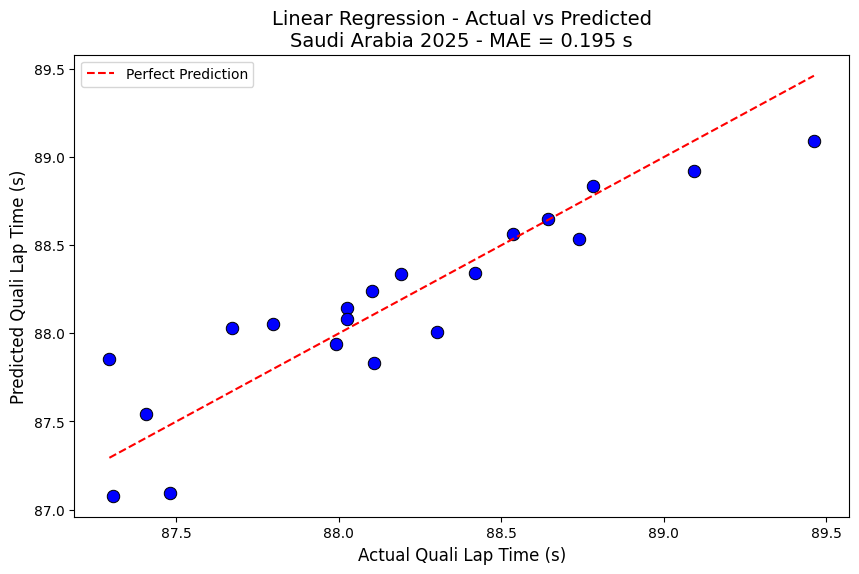

Linear Regression - MAE: 0.195 seconds


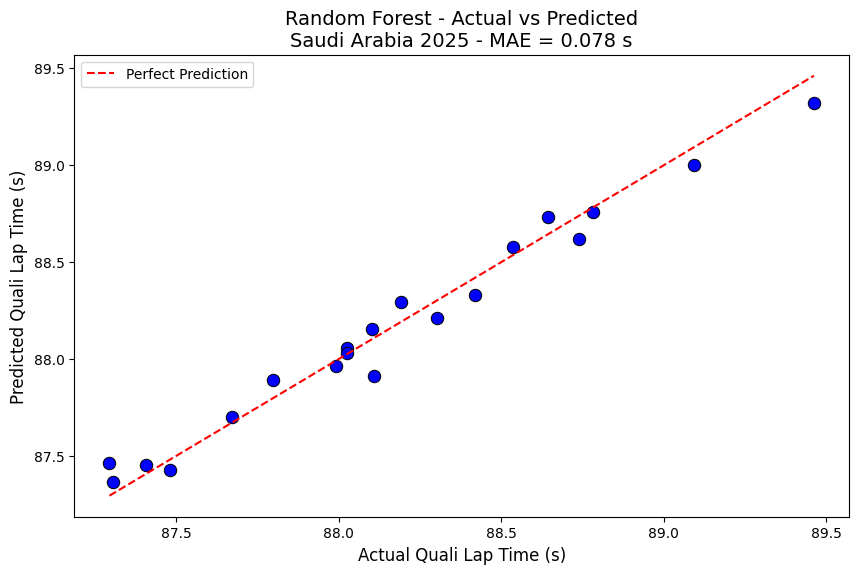

Random Forest - MAE: 0.078 seconds


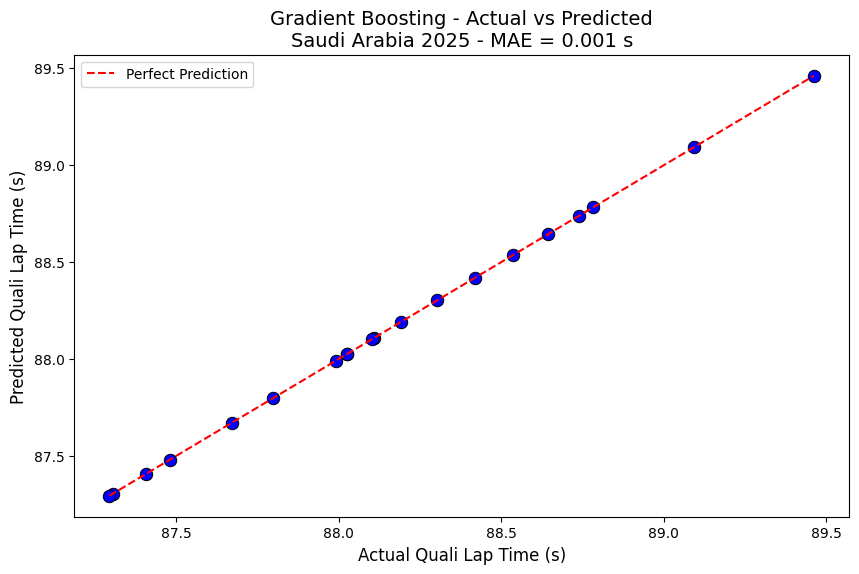

Gradient Boosting - MAE: 0.001 seconds


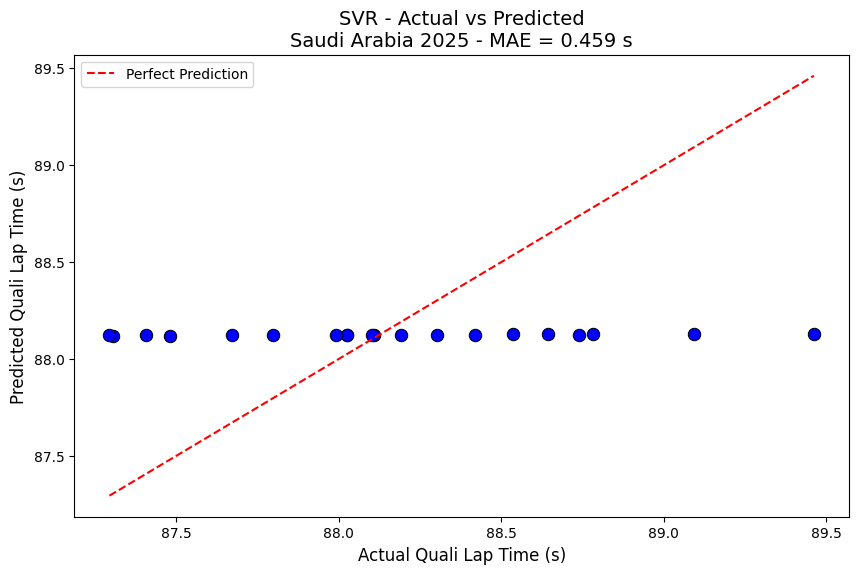

SVR - MAE: 0.459 seconds


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

# Features (X) and target (y)
X = data.drop(columns=['Driver', 'LapTime_Q'])
y = data['LapTime_Q']

# Plotting for all models
for model_name, model in models.items():
    # Train the model
    model.fit(X, y)
    
    # Predict the lap times
    preds = model.predict(X)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, preds)
    
    # Create a new column for predicted lap times
    data['Predicted_Q'] = preds
    
    # Plot: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='LapTime_Q', y='Predicted_Q', color='blue', s=80, edgecolor='black')
    plt.plot([data['LapTime_Q'].min(), data['LapTime_Q'].max()],
             [data['LapTime_Q'].min(), data['LapTime_Q'].max()],
             '--', color='red', label='Perfect Prediction')
    plt.xlabel('Actual Quali Lap Time (s)', fontsize=12)
    plt.ylabel('Predicted Quali Lap Time (s)', fontsize=12)
    plt.title(f'{model_name} - Actual vs Predicted\n{race_name} {year} - MAE = {mae:.3f} s', fontsize=14)
    plt.legend()
    plt.show()


    # Optionally, print out the Mean Absolute Error (MAE)
    print(f"{model_name} - MAE: {mae:.3f} seconds")



### Getting the Predications 

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Define a function to format time in F1 style (mm:ss.mmm)
def format_f1_time(seconds):
    if pd.isna(seconds):
        return "-"
    minutes = int(seconds // 60)
    sec = seconds % 60
    return f"{minutes}:{sec:06.3f}"

# Initialize models
models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR()
}

# Features (X) and target (y)
X = data.drop(columns=['Driver', 'LapTime_Q'])
y = data['LapTime_Q']

# Predict and display results for each model
for model_name, model in models.items():
    # Train the model
    model.fit(X, y)
    
    # Predict the lap times
    preds = model.predict(X)
    
    # Add predictions to the data
    data['Predicted_Q'] = preds
    
    # Create a fresh copy to avoid overwriting
    results = data[['Driver', 'LapTime_Q', 'Predicted_Q']].copy()
    
    # Calculate the error (absolute difference) between actual and predicted lap times
    results['Error (s)'] = (results['LapTime_Q'] - results['Predicted_Q']).abs().round(3)
    
    # Format lap times nicely
    results['Actual_Q'] = results['LapTime_Q'].apply(format_f1_time)
    results['Predicted_Q'] = results['Predicted_Q'].apply(format_f1_time)
    
    # Sort by actual lap time (fastest first)
    results = results.sort_values(by='LapTime_Q')
    
    # Display results for the current model
    print(f"\n{model_name} - Predictions and Errors")
    print(results[['Driver', 'Actual_Q', 'Predicted_Q', 'Error (s)']].to_string(index=False))



Gradient Boosting - Predictions and Errors
Driver Actual_Q Predicted_Q  Error (s)
   VER 1:27.294    1:27.295      0.001
   PIA 1:27.304    1:27.305      0.001
   RUS 1:27.407    1:27.407      0.000
   NOR 1:27.481    1:27.481      0.000
   LEC 1:27.670    1:27.669      0.001
   ANT 1:27.798    1:27.799      0.001
   TSU 1:27.990    1:27.989      0.001
   SAI 1:28.024    1:28.025      0.001
   GAS 1:28.025    1:28.025      0.000
   HAM 1:28.102    1:28.102      0.000
   ALB 1:28.109    1:28.108      0.001
   LAW 1:28.191    1:28.191      0.000
   ALO 1:28.303    1:28.303      0.000
   HAD 1:28.418    1:28.418      0.000
   BEA 1:28.536    1:28.536      0.000
   STR 1:28.645    1:28.646      0.001
   DOO 1:28.739    1:28.737      0.002
   HUL 1:28.782    1:28.782      0.000
   OCO 1:29.092    1:29.092      0.000
   BOR 1:29.462    1:29.461      0.001

Random Forest - Predictions and Errors
Driver Actual_Q Predicted_Q  Error (s)
   VER 1:27.294    1:27.456      0.162
   PIA 1:27.304    

### Seeing Which Model Performs Better with a graph

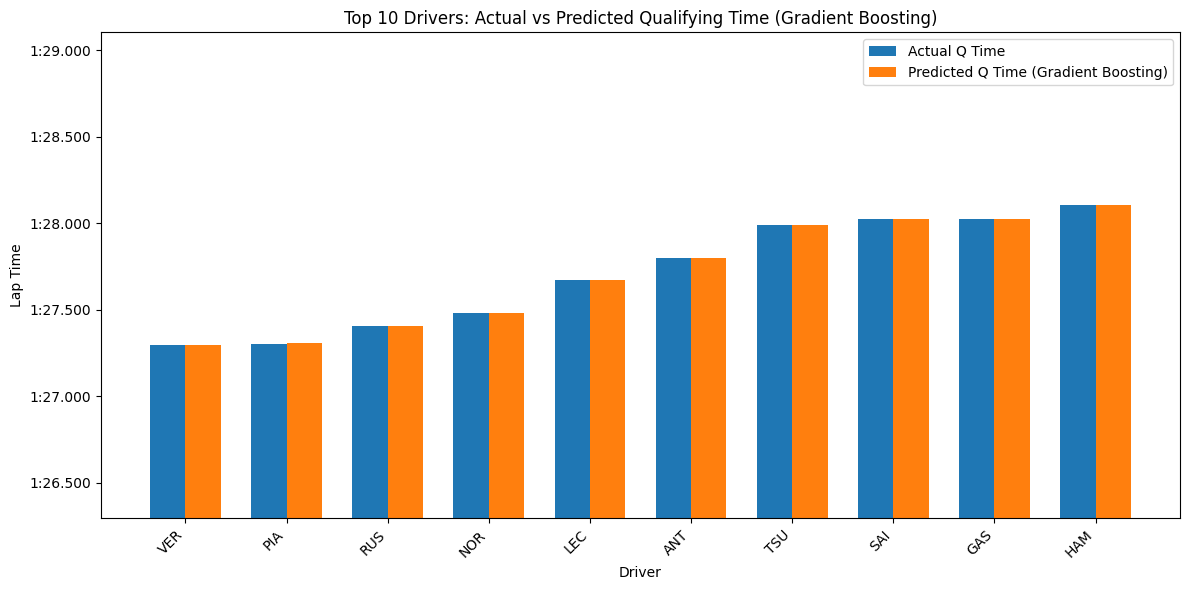

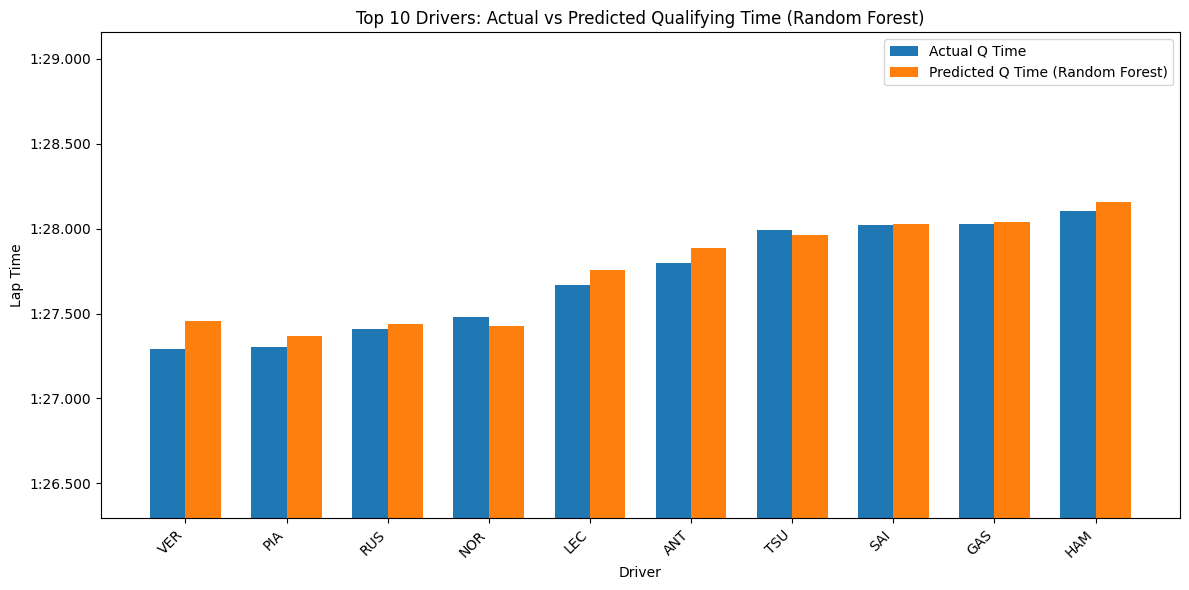

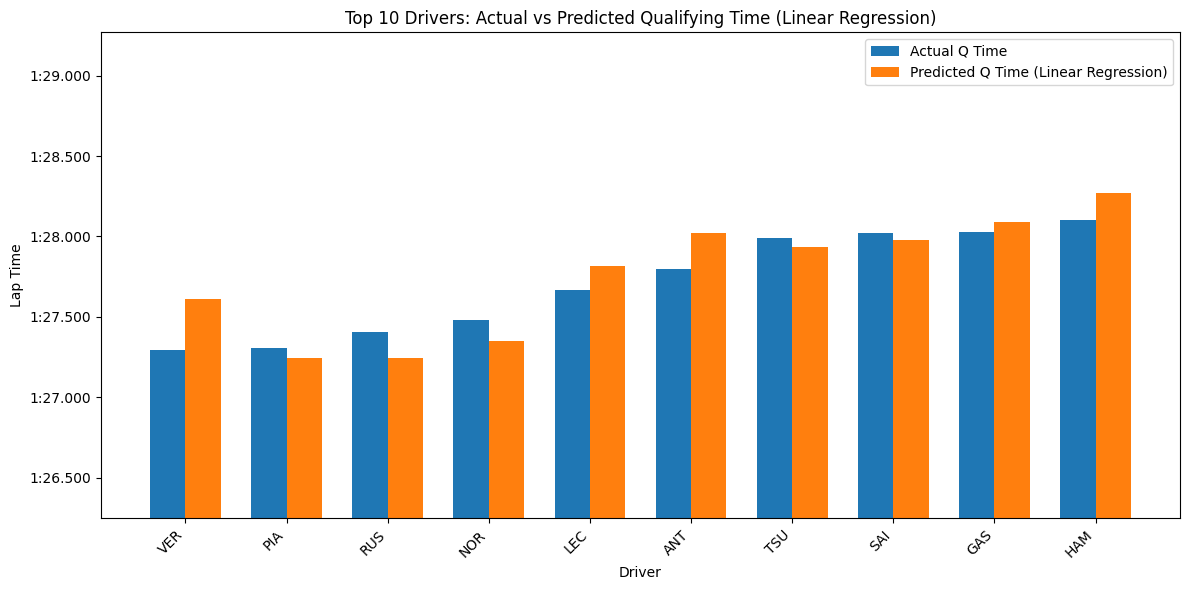

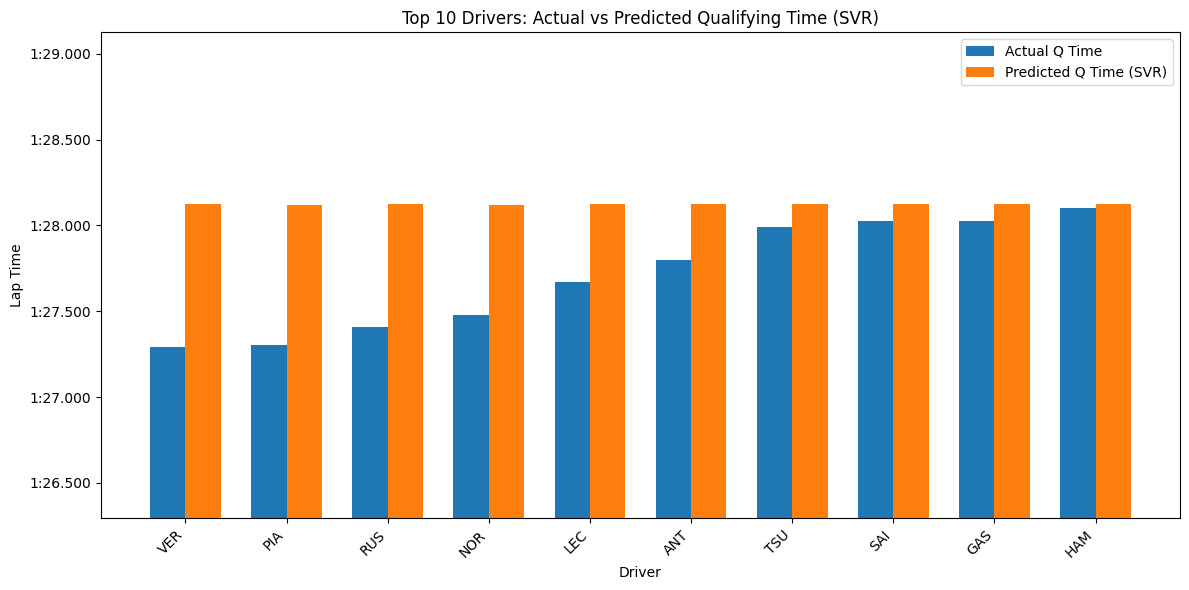

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Define the models
models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR()
}

# Format mm:ss.mmm for y-axis
def format_mmss(x, pos):
    minutes = int(x // 60)
    seconds = x % 60
    return f'{minutes}:{seconds:06.3f}'

# Loop through models
for model_name, model in models.items():
    model.fit(X, y)
    preds = model.predict(X)
    
    # Store predictions
    data['Predicted_Q'] = preds
    
    # Copy and filter top 10 by actual time
    results = data[['Driver', 'LapTime_Q', 'Predicted_Q']].copy()
    results = results.sort_values(by='LapTime_Q').head(10)

    # Plot setup
    x = np.arange(len(results))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Bars
    ax.bar(x - width/2, results['LapTime_Q'], width, label='Actual Q Time')
    ax.bar(x + width/2, results['Predicted_Q'], width, label=f'Predicted Q Time ({model_name})')
    
    # Labels and ticks
    ax.set_xlabel('Driver')
    ax.set_ylabel('Lap Time')
    ax.set_title(f'Top 10 Drivers: Actual vs Predicted Qualifying Time ({model_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(results['Driver'], rotation=45, ha='right')
    
    # Format y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))

    # Zoom in y-axis for better clarity
    min_time = min(results['LapTime_Q'].min(), results['Predicted_Q'].min())
    max_time = max(results['LapTime_Q'].max(), results['Predicted_Q'].max())
    ax.set_ylim(min_time - 1, max_time + 1)
    
    ax.legend()
    plt.tight_layout()
    plt.show()


## Final insights 

In this analysis, we utilized lap time data from Final Practice 3 (FP3) sessions to train various machine learning models aimed at predicting Qualifying session performance.
1) Gradient Boosting consistently delivered the most accurate predictions among the models, closely matching actual qualifying lap times for the top 10 drivers. This is likely due to its ability to handle complex non-linear relationships.
2) Random Forest offered solid performance, though slightly less precise than Gradient Boosting. It captures non-linearities but may struggle slightly with overfitting on smaller datasets.
3) Linear Regression, while simple and interpretable, showed larger prediction errors. It tends to underfit the data, especially where lap times are influenced by more nuanced factors like tire strategy, fuel load, or driver confidence.

4) SVR (Support Vector Regression) had the widest range in prediction error. It can be very sensitive to parameter tuning and scaling, which may explain its relative inconsistency without hyperparameter optimization.